In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

class QLearningAgent:
    def __init__(self, learning_rate, gamma, epsilon, state_bins, action_bins):
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.state_bins = state_bins
        self.action_bins = action_bins
        self.q_table = np.zeros(rating_bins + [2] * num_problem_categories + [len(duration_bins)] + [action_bins])
        self.duration_bins = None

    def discretize_state(self, state):
        rating_bins_edges = [0, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2700, 3000, 3001]
        rating_idx = np.digitize(state[0], bins=rating_bins_edges) - 1
        
        # Adjust to handle tags separated by both semicolons and commas
        problem_categories = [0] * num_problem_categories
        tags_in_state = [tag.strip() for sublist in state[1].split(';') for tag in sublist.split(',') if tag.strip()]
        for tag in tags_in_state:
            if tag in limited_tags:
                problem_categories[limited_tags.index(tag)] = 1
        
        duration_idx = np.digitize(state[2], bins=self.duration_bins) - 1
        return tuple([rating_idx] + problem_categories + [duration_idx])

    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_bins)
        else:
            return np.argmax(self.q_table[state])

    def update(self, state, action_value, reward, next_state, done):
        # Map action value to index
        action_index = action_to_index[action_value]
        future_optimal_value = np.max(self.q_table[next_state])
        learned_value = reward + self.gamma * future_optimal_value
        old_value = self.q_table[state][action_index]
        self.q_table[state][action_index] += self.learning_rate * (learned_value - old_value)

def get_next_contest_state(data, episode):
    contest_data = data.iloc[episode]
    state = (
        contest_data['Old Rating'],
        contest_data['Problem Tags'],  # Extract as a string
        contest_data['Contest Duration']
    )
    return state

def simulate_next_contest(data, episode, action):
    current_rating = data.iloc[episode]['Old Rating']
    predicted_next_rating = current_rating + action
    actual_next_rating = data.iloc[episode]['New Rating']
    actual_rating_change = actual_next_rating - current_rating
    next_state = (
        actual_next_rating,
        data.iloc[episode + 1]['Problem Tags'] if episode + 1 < len(data) else '',  # Ensure this is a string of tags
        data.iloc[episode + 1]['Contest Duration'] if episode + 1 < len(data) else 0
    )
    return next_state, actual_rating_change

def calculate_reward(action, actual_rating_change):
    return -abs(action - actual_rating_change)

# Read the CSV file
data = pd.read_csv('./tourist_problem.csv')

# Automatically determine duration bins based on unique values
unique_durations = sorted(data['Contest Duration'].unique())
duration_bins = np.array(unique_durations + [max(unique_durations) + 1])

# Extract unique problem tags
all_tags = '; '.join(data['Problem Tags'])
tags_split = [tag.strip() for sublist in all_tags.split(';') for tag in sublist.split(',') if tag.strip()]
unique_tags = set(tags_split)
print(f"Problem Categories: {len(unique_tags)}")
# Limit to first 20 unique tags
limited_tags = list(unique_tags)[:20]
num_problem_categories = len(limited_tags)

# Split the data into training and testing sets
train_data = data.iloc[:int(0.8 * len(data))]
test_data = data.iloc[int(0.8 * len(data)):]

# Hyperparameters
alpha = 0.1
gamma = 0.95
epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.995
num_episodes = len(train_data)
max_steps_per_episode = 100

rating_bins = [12]  # 12 bins for ratings
problem_category_bins = [2] * num_problem_categories

action_values = np.arange(-200, 201, 10)  # Actions from -200 to +200 in steps of 10
action_bins = len(action_values)  # This should be the number of actions
action_to_index = {v: i for i, v in enumerate(action_values)}

# Instantiate the QLearningAgent
q_learning_agent = QLearningAgent(alpha, gamma, epsilon, rating_bins + problem_category_bins + [len(duration_bins)], action_bins)
q_learning_agent.duration_bins = duration_bins  # Set duration bins

epochs = 100  # Number of times to iterate over the training dataset

for epoch in tqdm(range(epochs)):
    # Training loop
    for episode in range(num_episodes):
        state = get_next_contest_state(train_data, episode)
        state = q_learning_agent.discretize_state(state)
        done = False
        step = 0

        while not done and step < max_steps_per_episode:
            action_index = q_learning_agent.choose_action(state)
            # Convert action index to value
            action_value = action_values[action_index]

            next_state, actual_rating_change = simulate_next_contest(train_data, episode, action_value)
            next_state = q_learning_agent.discretize_state(next_state)
            reward = calculate_reward(action_value, actual_rating_change)
            q_learning_agent.update(state, action_value, reward, next_state, done)
            state = next_state
            step += 1
            if episode + 1 == len(train_data):
                done = True
                
        if epsilon > min_epsilon:
            epsilon *= decay_rate

Problem Categories: 36


100%|██████████| 100/100 [12:54<00:00,  7.75s/it]


Mean Squared Error on Test Data: 26959.764705882353


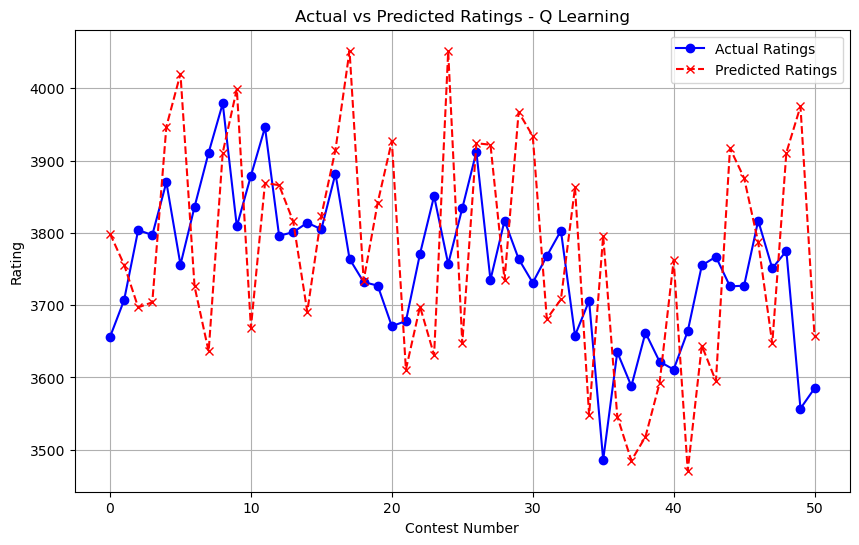

In [3]:
import matplotlib.pyplot as plt

# Evaluation on test data and calculate MSE
test_predictions = []
test_actuals = []
episodes = []

for episode in range(len(test_data)):
    episodes.append(episode)
    state = get_next_contest_state(test_data, episode)
    state = q_learning_agent.discretize_state(state)
    action_index = q_learning_agent.choose_action(state)
    action_value = action_values[action_index]

    predicted_rating_change = action_value
    actual_next_rating = test_data.iloc[episode]['New Rating']
    predicted_next_rating = test_data.iloc[episode]['Old Rating'] + predicted_rating_change

    test_predictions.append(predicted_next_rating)
    test_actuals.append(actual_next_rating)

mse = np.mean((np.array(test_predictions) - np.array(test_actuals)) ** 2)
print(f"Mean Squared Error on Test Data: {mse}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(episodes, test_actuals, label='Actual Ratings', color='blue', marker='o')
plt.plot(episodes, test_predictions, label='Predicted Ratings', color='red', linestyle='dashed', marker='x')
plt.title('Actual vs Predicted Ratings - Q Learning')
plt.xlabel('Contest Number')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
# Save the figure
plt.savefig('actual_vs_predicted_ratings_q_learning.png', dpi=1200)  # Adjust the file name and dpi as needed
plt.show()
